# XGBoost Model
### Imports

In [2]:
import os
import json
import joblib
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid

### Paths

In [3]:
DATA_DIR = "../data/splits"
MODEL_DIR = "../models/xgboost"
os.makedirs(MODEL_DIR, exist_ok=True)

TRAIN_PATH = f"{DATA_DIR}/train.csv"
VAL_PATH   = f"{DATA_DIR}/val.csv"
TEST_PATH  = f"{DATA_DIR}/test.csv"

TARGET_COL = "target"
SEED = 42

### Loading Data

In [4]:
train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]

X_val = val_df.drop(columns=[TARGET_COL])
y_val = val_df[TARGET_COL]

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

classes = sorted(y_train.unique().tolist())
print("Classes:", classes)

Train: (3096, 36)
Val  : (664, 36)
Test : (664, 36)
Classes: ['Dropout', 'Enrolled', 'Graduate']


### Label Encoding

In [5]:
label_to_id = {c:i for i,c in enumerate(classes)}
id_to_label = {i:c for c,i in label_to_id.items()}

y_train_id = y_train.map(label_to_id).astype(int)
y_val_id   = y_val.map(label_to_id).astype(int)
y_test_id  = y_test.map(label_to_id).astype(int)

label_to_id, id_to_label

({'Dropout': 0, 'Enrolled': 1, 'Graduate': 2},
 {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'})

### Training XGBoost

In [6]:
base_model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    eval_metric="mlogloss",
    tree_method="hist"
)

base_model.fit(X_train, y_train_id)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [7]:
val_pred_id = base_model.predict(X_val)
val_acc = accuracy_score(y_val_id, val_pred_id)

print("Validation Accuracy:", round(val_acc, 4))
print("\nClassification Report (Validation):")
print(classification_report(y_val_id, val_pred_id, target_names=classes))

Validation Accuracy: 0.753

Classification Report (Validation):
              precision    recall  f1-score   support

     Dropout       0.78      0.72      0.75       213
    Enrolled       0.51      0.41      0.46       119
    Graduate       0.80      0.90      0.85       332

    accuracy                           0.75       664
   macro avg       0.70      0.68      0.68       664
weighted avg       0.74      0.75      0.74       664



### Hyperparameter tuning

In [8]:
param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05],
    "n_estimators": [300, 500],
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.8, 0.9],
}

best_acc = -1
best_params = None
best_model = None

for params in ParameterGrid(param_grid):
    model = XGBClassifier(
        objective="multi:softprob",
        num_class=len(classes),
        random_state=SEED,
        eval_metric="mlogloss",
        tree_method="hist",
        reg_lambda=1.0,
        **params
    )
    model.fit(X_train, y_train_id)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val_id, pred)

    if acc > best_acc:
        best_acc = acc
        best_params = params
        best_model = model

best_acc, best_params

(0.7740963855421686,
 {'colsample_bytree': 0.8,
  'learning_rate': 0.03,
  'max_depth': 4,
  'n_estimators': 500,
  'subsample': 0.8})

### Save best parameters

In [9]:
with open(f"{MODEL_DIR}/best_params.json", "w") as f:
    json.dump(best_params, f, indent=2)
print("Saved best_params.json")

Saved best_params.json


### Test Evaluation

In [10]:
test_pred_id = best_model.predict(X_test)
test_acc = accuracy_score(y_test_id, test_pred_id)
cm = confusion_matrix(y_test_id, test_pred_id)

print("Test Accuracy:", round(test_acc, 4))
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report (Test):")
print(classification_report(y_test_id, test_pred_id, target_names=classes))

Test Accuracy: 0.8042

Confusion Matrix:
 [[168  23  23]
 [ 17  60  42]
 [  8  17 306]]

Classification Report (Test):
              precision    recall  f1-score   support

     Dropout       0.87      0.79      0.83       214
    Enrolled       0.60      0.50      0.55       119
    Graduate       0.82      0.92      0.87       331

    accuracy                           0.80       664
   macro avg       0.77      0.74      0.75       664
weighted avg       0.80      0.80      0.80       664



### Saving Metrics

In [11]:
metrics = {
    "model": "XGBoost",
    "classes": classes,
    "label_to_id": label_to_id,
    "accuracy": float(test_acc),
    "confusion_matrix": cm.tolist(),
    "classification_report": classification_report(
        y_test_id, test_pred_id, target_names=classes, output_dict=True
    ),
    "best_params": best_params
}

with open(f"{MODEL_DIR}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved metrics.json")

Saved metrics.json


### Saving Confusion Matrix

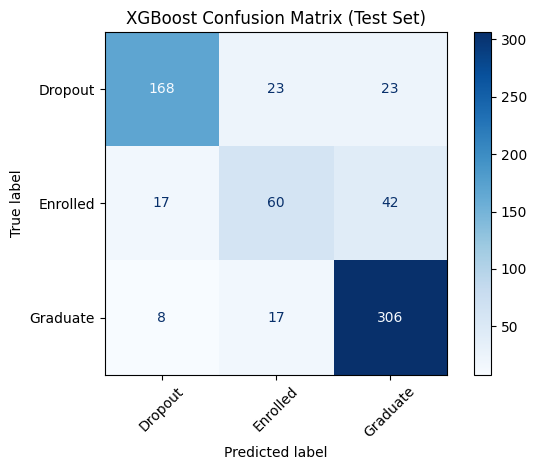

Saved: ../models/xgboost/confusion_matrix.png


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm_xgb = confusion_matrix(y_test_id, test_pred_id)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb,
    display_labels=classes
)

disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.tight_layout()

xgb_cm_path = "../models/xgboost/confusion_matrix.png"
plt.savefig(xgb_cm_path)
plt.show()

print("Saved:", xgb_cm_path)

### Feature Importance

In [12]:
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_model.feature_importances_
}).sort_values(by="importance", ascending=False)

importance_df.to_csv(f"{MODEL_DIR}/feature_importance.csv", index=False)
importance_df.head(10)

,feature,importance
30,num__curricular_units_2nd_sem_approved,0.173401
14,cat__tuition_fees_up_to_date,0.081833
24,num__curricular_units_1st_sem_approved,0.055207
22,num__curricular_units_1st_sem_enrolled,0.047120
31,num__curricular_units_2nd_sem_grade,0.037380
16,cat__scholarship_holder,0.036081
28,num__curricular_units_2nd_sem_enrolled,0.036027
23,num__curricular_units_1st_sem_evaluations,0.030904
13,cat__debtor,0.028027
29,num__curricular_units_2nd_sem_evaluations,0.027802


### Saving Model

In [13]:
joblib.dump(best_model, f"{MODEL_DIR}/model.joblib")
print("Saved model.joblib")

Saved model.joblib
